# US48 Demand for Electricity Forecast

## Loading required libraries

In [8]:
import os
import pandas as pd
from statsforecast import StatsForecast
import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt


from statsforecast.models import (
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA as AA,
    AutoETS as AE,
    AutoTBATS as AT,
     MSTL

)

from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from window_ops.expanding import expanding_mean
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go

## Loading the Data

In [9]:
data = pd.read_csv("data/us48.csv")
data["ds"] = pd.to_datetime(data["period"])
end = data["ds"].max().floor(freq = "d") - datetime.timedelta(hours = 1)
start = end - datetime.timedelta(hours = 24 * 30 * 25)
data = data[(data["ds"] <= end) & (data["ds"] >= start)]
data = data.sort_values(by = "ds")
data = data[["ds", "value"]]
data = data.rename(columns = {"ds": "ds", "value": "y"})
data["unique_id"] = 1


data.head()

,ds,y,unique_id
59322,2022-04-06 23:00:00,462894.0,1
59323,2022-04-07 00:00:00,463663.0,1
59324,2022-04-07 01:00:00,464916.0,1
59325,2022-04-07 02:00:00,459376.0,1
59326,2022-04-07 03:00:00,441989.0,1


In [10]:
p = go.Figure()
p.add_trace(go.Scatter(x = data["ds"], y = data["y"],
                       mode='lines',
                    name='data',
                    line=dict(color='royalblue', width=2)))
p.show()

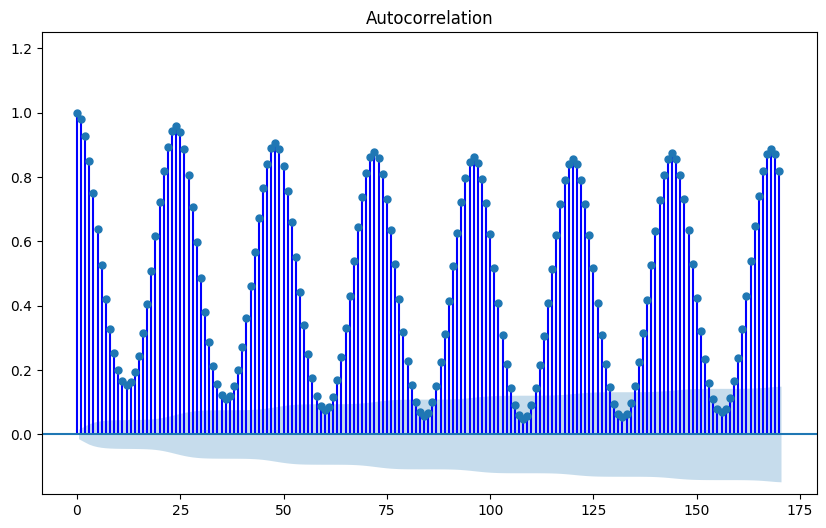

In [11]:
from matplotlib.collections import PolyCollection
curr_fig, curr_ax = plt.subplots(figsize=(10, 6))

sm.graphics.tsa.plot_acf(data["y"].values.squeeze(), lags = 170, ax=curr_ax, vlines_kwargs={"colors": "blue"}, adjusted= True, auto_ylims= True)
plt.show()

## Train Forecasting Models

In [12]:

stats_models = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=[24, 24 * 7]),
    HistoricAverage(),
    DOT(season_length=[24, 24 * 7]),
    AA(),
    # AE(season_length=[24, 24 * 7]),
    # AT(season_length=[24, 24 * 7]),
    MSTL(
    season_length=[24, 24 * 7], 
    trend_forecaster=AA() 
)
]


sf = StatsForecast( 
    models=stats_models,
    freq="H", 
    fallback_model = SeasonalNaive(season_length=24),
    n_jobs= -1,
)

forecasts_stats = sf.forecast(df=data, h=72, level=[95])
forecasts_stats.head()

/opt/forecasting-poc/lib/python3.10/site-packages/utilsforecast/processing.py:384: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/opt/forecasting-poc/lib/python3.10/site-packages/utilsforecast/processing.py:438: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/opt/forecasting-poc/lib/python3.10/site-packages/statsforecast/core.py:492: FutureWarning:

In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.



,ds,HoltWinters,HoltWinters-lo-95,HoltWinters-hi-95,CrostonClassic,CrostonClassic-lo-95,CrostonClassic-hi-95,SeasonalNaive,SeasonalNaive-lo-95,SeasonalNaive-hi-95,...,HistoricAverage-hi-95,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-95,DynamicOptimizedTheta-hi-95,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95,MSTL,MSTL-lo-95,MSTL-hi-95
unique_id,,,,,,,,,,,,,,,,,,,,,
1,2024-04-26 00:00:00,461404.46875,388244.56250,534564.37500,461404.46875,388244.56250,534564.37500,461404.46875,388244.56250,534564.37500,...,613615.375,461404.46875,388244.56250,534564.37500,460985.00000,452335.21875,469634.75000,458414.09375,455325.87500,461502.34375
1,2024-04-26 01:00:00,460745.93750,387586.03125,533905.87500,460745.93750,387586.03125,533905.87500,460745.93750,387586.03125,533905.87500,...,613615.375,460745.93750,387586.03125,533905.87500,461947.46875,439318.87500,484576.06250,459890.90625,454694.00000,465087.81250
1,2024-04-26 02:00:00,454455.65625,381295.75000,527615.56250,454455.65625,381295.75000,527615.56250,454455.65625,381295.75000,527615.56250,...,613615.375,454455.65625,381295.75000,527615.56250,462190.06250,421840.81250,502539.34375,454525.81250,447112.34375,461939.28125
1,2024-04-26 03:00:00,437894.50000,364734.59375,511054.40625,437894.50000,364734.59375,511054.40625,437894.50000,364734.59375,511054.40625,...,613615.375,437894.50000,364734.59375,511054.40625,461990.78125,402143.12500,521838.43750,437893.06250,428387.28125,447398.87500
1,2024-04-26 04:00:00,417135.37500,343975.46875,490295.28125,417135.37500,343975.46875,490295.28125,417135.37500,343975.46875,490295.28125,...,613615.375,417135.37500,343975.46875,490295.28125,461571.37500,381994.75000,541148.00000,417463.40625,406093.21875,428833.56250


/opt/forecasting-poc/lib/python3.10/site-packages/statsforecast/core.py:1447: FutureWarning:

Passing the ids as the index is deprecated. Please provide them as a column instead.



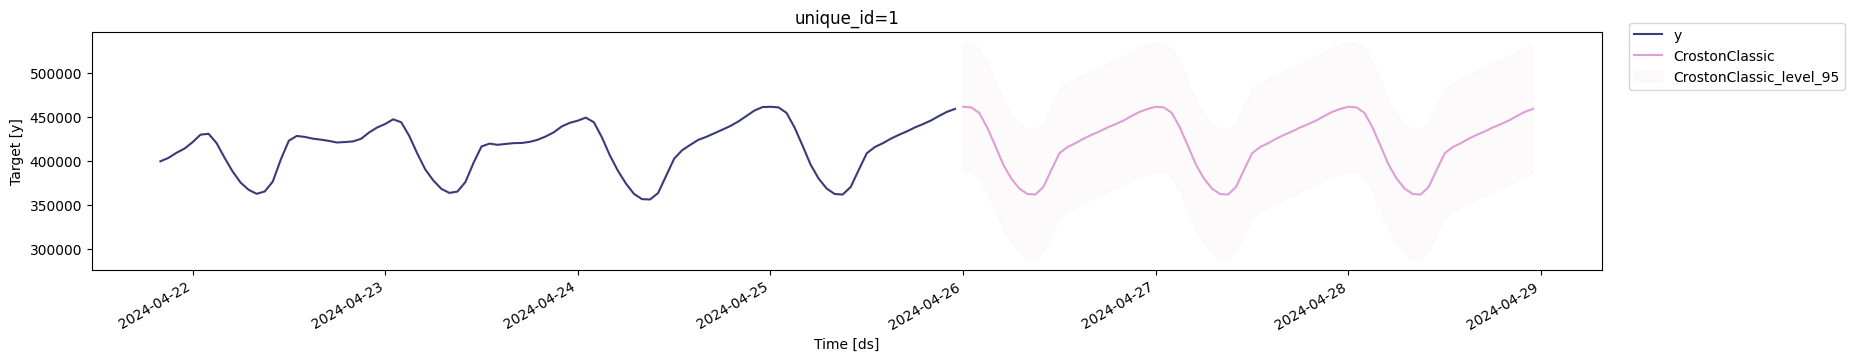

In [13]:
sf.plot(data.tail(100),forecasts_stats,  models=["CrostonClassic"], level=[95])